In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import spacy
import torch.optim as optim
import numpy as np
import torch
from collections import defaultdict
from collections import Counter
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('IMDB_Dataset.csv')
nlp = spacy.load("en_core_web_sm")



In [3]:
explore_data=list()

In [4]:
for i,rev in enumerate(df.sample(n = 5000, replace = False)["review"]):
    if i % 500 == 0:
        print(i)
    sents = list()
    doc=nlp(rev, disable = ["ner", "tagger"])
    for j,sent in enumerate(doc.sents):
        sents.append(sent)
    explore_data.append(sents)
    


0
500
1000
1500
2000
2500
3000
3500
4000
4500


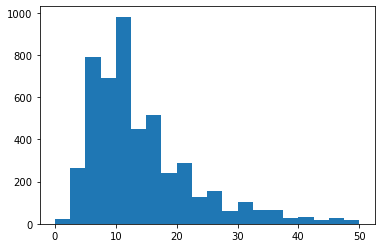

In [192]:
lengths = list()
for l in explore_data:
    lengths.append(len(l))
lengths
plt.hist(lengths, range=(0,50), bins=20)
plt.show()

In [142]:
train_mini = list()
for i,rev in enumerate(df["review"][:25000]):
    if i % 500 == 0:
        print(i)
    sents = list()
    doc=nlp(rev, disable = ["ner", "tagger"])
    for j,sent in enumerate(doc.sents):
        if j == 10: # avg length of sents
            break
        sents.append(str(sent))
    train_mini.append(sents)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500


In [ ]:
train_mini

In [143]:
def clean(data):
    clean_data = list()
    for review in data:
        clean_sents = list()
        for sent in review:
            doc = nlp(sent, disable = ["ner", "parser", "tagger"])
            tokens = list()
            for token in doc:
                if token.is_alpha and not token.is_stop and len(token.text) > 2:
                    tokens.append(token.lemma_.lower())
            if len(tokens) > 0:
                clean_sents.append(" ".join(tokens)) 
        clean_data.append(clean_sents)
    return clean_data

In [144]:
clean_mini = clean(train_mini)

In [ ]:
" ".join(clean_mini[7])

In [145]:
def make_voc(data, max_size = 10000):
    vocab = defaultdict(int)
    vocab["<pad>"] = 0
    all_words = list()
    word_id = 1
    for rev in data:
        for word in " ".join(rev).split(" "):
            all_words.append(word)
    freq = Counter(all_words)
    words = freq.most_common(max_size - len(vocab))
    word_id = 1
    for word,freq in words:
        vocab[word] += word_id
        word_id += 1
    return vocab

In [10]:
vocab_mini = make_voc(clean_mini)
vocab_mini

defaultdict(int,
            {'<pad>': 0,
             'movie': 1,
             'film': 2,
             'like': 3,
             'watch': 4,
             'time': 5,
             'story': 6,
             'think': 7,
             'see': 8,
             'character': 9,
             'good': 10,
             'know': 11,
             'great': 12,
             'well': 13,
             'bad': 14,
             'scene': 15,
             'people': 16,
             'play': 17,
             'look': 18,
             'way': 19,
             'love': 20,
             'plot': 21,
             'get': 22,
             'act': 23,
             'find': 24,
             'go': 25,
             'come': 26,
             'man': 27,
             'end': 28,
             'work': 29,
             'thing': 30,
             'make': 31,
             'little': 32,
             'actor': 33,
             'life': 34,
             'try': 35,
             'want': 36,
             'year': 37,
             'feel': 38,
          

In [146]:
def prepare_sequence(seq, vocab):
    idxs = [vocab[w] if w in vocab else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [147]:
def prep_train(data):
    train = list()
    for rev in data:
        sents = list()
        for sent in rev:
            sents.append(prepare_sequence(sent.split(" "), vocab_mini))
        train.append(sents)
    return train

In [148]:
train_mini = prep_train(clean_mini)
sent_mini = np.array(df["sentiment"][:25000], dtype=np.int64)

In [269]:
class lstm_vectorizer(nn.Module):

    def __init__(self, embedding_dim=512, hidden_dim=256, vocab_size=10000):
        super(lstm_vectorizer, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        
        embeds = embeds.to("cuda")

        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        
        lstm_out = lstm_out.to("cuda")
        
        #hidden = self.hidden(lstm_out)
        return torch.mean(lstm_out.squeeze(1), axis=0) # torch.mean(hidden, axis=0)
    

In [268]:
class MLP(nn.Module): 
    def __init__(self, embdim = 512, hidden_unit = 100, output_dim = 2):
        super().__init__()
        self.hidden = nn.Linear(10 * embdim, hidden_unit)
        self.output = nn.Linear(hidden_unit, output_dim)

    def forward(self, features):
        hn = self.hidden(features)
        out = self.output(hn)
        
        return out  

In [270]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = lstm_vectorizer()
        self.mlp = MLP()

    def forward(self, review):
        #need 10 outputs concat
        lstm_vector = [self.lstm.forward(sent.to("cuda")) for sent in review]
        lstm_vector.extend([torch.FloatTensor(512 *[0]).to("cuda")] * (10 - len(lstm_vector))) # padding
        lstm_vector = lstm_vector
        input_mlp = torch.cat(lstm_vector).to("cuda")
        input_mlp = input_mlp.to("cuda")
        output_mlp = self.mlp.forward(input_mlp)
        output_mlp = output_mlp.to("cuda")
        return output_mlp

net = net()

In [271]:
def train_net(model, revs, sents):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    m = nn.LogSoftmax(dim=1)
    
    for epoch in range(1):
        p = 0
        for i, rev in enumerate(revs[:10000]):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            
            target = torch.tensor([sents[i]])
            target = target.to("cuda")

            # Step 3. Run our forward pass.
            forward = model(rev)
            forward = forward.to("cuda")
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(m(forward.unsqueeze(0)), target)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                p+=1
                print("loss:", loss.item())
                print(p,"% ...")

In [272]:
net = net.to("cuda")
train_net(net, train_mini, sent_mini)

loss: 0.6474443078041077
1 % ...
loss: 0.7139332890510559
2 % ...
loss: 0.7376116514205933
3 % ...
loss: 0.5228411555290222
4 % ...
loss: 0.46148085594177246
5 % ...
loss: 0.5821271538734436
6 % ...
loss: 0.41785117983818054
7 % ...
loss: 0.527249813079834
8 % ...
loss: 0.9399275779724121
9 % ...
loss: 0.2312680035829544
10 % ...
loss: 0.0010920758359134197
11 % ...
loss: 0.03275252878665924
12 % ...
loss: 0.0003332536434754729
13 % ...
loss: 0.24712321162223816
14 % ...
loss: 0.4940148591995239
15 % ...
loss: 0.000556314189452678
16 % ...
loss: 1.0487689971923828
17 % ...
loss: 2.111652374267578
18 % ...
loss: 0.12464223057031631
19 % ...
loss: 0.15036459267139435
20 % ...
loss: 0.3545103669166565
21 % ...
loss: 0.2978688180446625
22 % ...
loss: 0.34357285499572754
23 % ...
loss: 0.0008294717408716679
24 % ...
loss: 0.17332836985588074
25 % ...
loss: 0.010815335437655449
26 % ...
loss: 0.7060902714729309
27 % ...
loss: 0.6943464875221252
28 % ...
loss: 0.3503696024417877
29 % ...
loss

0.828

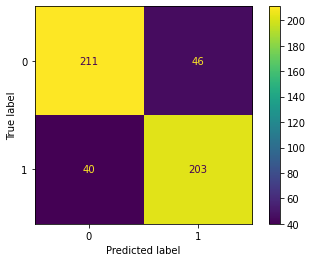

In [296]:

preds = list()
for rev in train_mini[12000:12500]:
    with torch.no_grad():
        scores = net(rev)
        probs = torch.exp(scores)
        preds.append(torch.argmax(probs.unsqueeze(0), dim=1)[0].item())

golds = sent_mini[12000:12500]
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)

In [38]:

out = net.forward(train_mini[0])
m = nn.LogSoftmax(dim=0)
m(out)

tensor([-0.6976, -0.6888], grad_fn=<LogSoftmaxBackward>)

In [14]:
# BINARY not text
for i, row in df.iterrows():
    if row["sentiment"] == "positive":
        df.at[i,'sentiment'] = 1
    else:
        df.at[i,'sentiment'] = 0
        

In [47]:
#some cleaning

for i, row in df.iterrows():
    if i % 10000 == 0:
        print(i)
    doc = nlp(row["review"], disable = ["ner", "parser", "tagger"])
    rev = list()
    for token in doc:
        if token.is_alpha and not token.is_stop and len(token.text) > 2:
            rev.append(token.lemma_.lower())
    df.at[i,"review"] = " ".join(rev)
            
        
    

0
10000
20000
30000
40000


In [48]:
def make_vocab(df, max_size = 10000):
    vocab = defaultdict(int)
    vocab["<pad>"] = 0
    vocab["<bos>"] = 1
    vocab["<eos>"] = 2
    vocab["<unk>"] = 3
    print(vocab)
    # do counter
    #get most common
    #put in dict. 
    all_words = list()
    word_id = 4
    for i, row in df.iterrows():
        if i % 10000 == 0:
            print(i)
        for word in row["review"].split(" "):
            all_words.append(word)
    freq = Counter(all_words)
    words = freq.most_common(max_size - len(vocab))
    print(len(words))
    word_id = 4
    for word,freq in words:
        vocab[word] += word_id
        word_id += 1
    return vocab
vocab = make_vocab(df)

defaultdict(<class 'int'>, {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3})
0
10000
20000
30000
40000
9996


In [ ]:
len(vocab)

In [49]:
def prepare_sequence(seq, vocab):
    idxs = [vocab[w] if w in vocab else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


In [ ]:
test = prepare_sequence(df.iloc[0]["review"].split(" "), vocab) 
test

#### prep training data and class

In [281]:
train_rev = list()
word_sents = list()
for i, rev in enumerate(df["review"].to_numpy()):
    word_sents.append(rev.split(" "))
    train_rev.append(prepare_sequence(rev.split(" "), vocab))
train_sent = df["sentiment"].to_numpy()



In [ ]:
word_sents

In [287]:
class LSTMclassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMclassifier, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.out = nn.Linear(2 * hidden_dim, 2)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = embeds.to("cuda")
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out = lstm_out.to("cuda")
        out = self.out(lstm_out) #lstm_out[-1]
        out = out.to("cuda")
        return torch.mean(out, axis=0)

In [288]:
lstm = LSTMclassifier(100,100,len(vocab),4)
lstm = lstm.to("cuda")



In [289]:
def train_lstm(model, revs, sents):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    m = nn.LogSoftmax(dim=1)
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    with torch.no_grad():
        first = revs[0]
        first = first.to("cuda")
        scores = model(first)
        print(scores)
    for epoch in range(1):  # again, normally you would NOT do 300 epochs, it is toy data
        p = 0
        for i, rev in enumerate(revs[:10000]):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.

            target = torch.tensor([sents[i]])
            target = target.to("cuda")
            rev = rev.to("cuda")
            # Step 3. Run our forward pass.
            predict = model(rev)
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(m(predict), target)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                p+=1
                print("loss:", loss.item())
                print(p,"% ...")
train_lstm(lstm, train_rev, train_sent)

tensor([[-0.0123,  0.0414]], device='cuda:0')
loss: 0.666625440120697
1 % ...
loss: 1.0152952671051025
2 % ...
loss: 0.4910854697227478
3 % ...
loss: 0.738742470741272
4 % ...
loss: 0.5944241285324097
5 % ...
loss: 0.5740475654602051
6 % ...
loss: 0.5242593884468079
7 % ...
loss: 1.699992299079895
8 % ...
loss: 0.557603120803833
9 % ...
loss: 0.30870094895362854
10 % ...
loss: 0.012244884856045246
11 % ...
loss: 1.3282191753387451
12 % ...
loss: 0.0005183068569749594
13 % ...
loss: 0.020454423502087593
14 % ...
loss: 0.22770552337169647
15 % ...
loss: 0.06272442638874054
16 % ...
loss: 0.3894866406917572
17 % ...
loss: 0.9748966693878174
18 % ...
loss: 0.03551144152879715
19 % ...
loss: 0.13445299863815308
20 % ...
loss: 0.3654627203941345
21 % ...
loss: 0.2110596001148224
22 % ...
loss: 0.7135845422744751
23 % ...
loss: 0.004338139668107033
24 % ...
loss: 0.013249566778540611
25 % ...
loss: 0.059060271829366684
26 % ...
loss: 0.1750289648771286
27 % ...
loss: 0.02778804861009121
28 % 

In [294]:
m = nn.LogSoftmax(dim=1)
#print(df.iloc[2]["review"])
preds = list()
for rev in train_rev[12000:12500]:
    with torch.no_grad():
        first = train_rev[2]
        rev = rev.to("cuda")
        scores = lstm(rev)
        probs = torch.exp(m(scores))
        #print(probs)
        #print(torch.argmax(probs, dim=1))
        preds.append(torch.argmax(probs, dim=1)[0].item())
        #print("gold: ", train_sent[2])
    

0.822

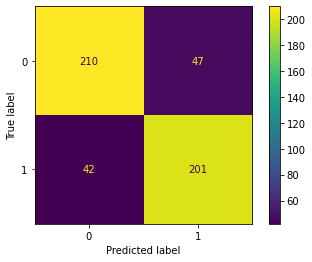

In [295]:

golds = train_sent[12000:12500]
preds
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)

### Baseline model logistic regression

In [ ]:
len(vocab)

In [ ]:
# bow 
def make_bow_vector(sentence, vocab):
    vec = torch.zeros(len(vocab))
    for word in sentence:
        if word in vocab:
            vec[vocab[word]] += 1
        else:
            vec[0] += 1
    return vec.view(1, -1)

In [ ]:
te = make_bow_vector(word_sents[0], vocab)
len(te)

In [ ]:
class lr(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(lr, self).__init__()

        # Define the parameters that you will need.  In this case, we need A and b,
        # the parameters of the affine mapping.
        # Torch defines nn.Linear(), which provides the affine map.
        # Make sure you understand why the input dimension is vocab_size
        # and the output is num_labels!
        self.linear = nn.Linear(vocab_size, num_labels) # do i do a cbow or can i cheat?

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, rev):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        out = self.linear(rev)
        out = out.to("cuda")
        return out
lr = lr(2, len(vocab))

In [ ]:
lr.forward(make_bow_vector(word_sents[0], vocab))
lr = lr.to("cuda")


In [ ]:
def train_lr(model, word_sents, sentiment, vocab):
    m = nn.LogSoftmax(dim=1)
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    with torch.no_grad():
        first = make_bow_vector(word_sents[0], vocab)
        first = first.to("cuda")
        scores = model(first)
        print(scores)
    p = 0
    for epoch in range(2):  # again, normally you would NOT do 300 epochs, it is toy data
        for i, rev in enumerate(word_sents[:49500]):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            bow_rev = make_bow_vector(rev, vocab)
            target = torch.tensor([sentiment[i]])
            target = target.to("cuda")
            bow_rev = bow_rev.to("cuda")
            # Step 3. Run our forward pass.
            predict = model(bow_rev)
            
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(m(predict), target)
            loss.backward()
            optimizer.step()
            if i % 495 == 0:
                p+=1
                print("loss:", loss.item())
                print(p,"% ...")
train_lr(lr, word_sents, train_sent, vocab)

In [ ]:
m = nn.LogSoftmax(dim=1)
#print(df.iloc[2]["review"])
preds = list()
for rev in word_sents[-500:]:
    with torch.no_grad():
        inp = make_bow_vector(rev, vocab)
        inp = inp.to("cuda")
        out = lr(inp)
        probs = torch.exp(m(out))
        #print(probs)
        #print(torch.argmax(probs, dim=1))
        preds.append(torch.argmax(probs, dim=1)[0].item())
        #print("gold: ", train_sent[2])

In [ ]:
#preds
print("hej")

In [ ]:
golds = train_sent[-500:]
preds
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)